# Import Required Libraries

In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import torch.nn.functional as F
import argparse
import matplotlib
import pandas as pd

from tqdm import tqdm
import glob
import os
from datetime import datetime
from itertools import product
import time
import math

import warnings
warnings.filterwarnings("ignore")

In [2]:
def hard_sigmoid(x):
    # Source : https://github.com/Laborieux-Axel/Equilibrium-Propagation/
    return (1+F.hardtanh(2*x-1))*0.5

def outer_prod_broadcasting(A, B):
    """Broadcasting trick"""
    return A[...,None]*B[:,None]

def torch2numpy(x):
    return x.detach().cpu().numpy()

def antisparse_clip(x):
    return torch.clip(x, -1, 1)

def evaluateContrastiveCorInfoMaxHopfield(model, loader, hopfield_g, neural_lr_start, neural_lr_stop,
                                          neural_lr_rule, neural_lr_decay_multiplier,
                                          T, device, printing = True):
    # Evaluate the Contrastive CorInfoMax Hopfield model on a dataloader with T steps for the dynamics for the classification task
    correct = 0
    phase = 'Train' if loader.dataset.train else 'Test'

    for x, y in loader:
        x = x.view(x.size(0),-1).to(device).T
        y = y.to(device)

        neurons = model.init_neurons(x.size(1), device = model.device)

        # dynamics for T time steps
        neurons, _, _ = model.run_neural_dynamics_hopfield(x, 0, neurons, hopfield_g, neural_lr_start, neural_lr_stop, neural_lr_rule, neural_lr_decay_multiplier, T, beta = 0)

        pred = torch.argmax(neurons[-1], dim=0).squeeze()
        correct += (y == pred).sum().item()

    acc = correct/len(loader.dataset)
    if printing:
        print(phase+' accuracy :\t', acc)
    return acc

class ContrastiveCorInfoMaxHopfield():

    def __init__(self, architecture, lambda_, epsilon, activation = hard_sigmoid, device = None):

        self.architecture = architecture
        self.lambda_ = lambda_
        self.gam_ = (1 - lambda_) / lambda_
        self.epsilon = epsilon
        self.one_over_epsilon = 1 / epsilon
        self.activation = activation
        if device is None:
            self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        else:
            self.device = device

        # Feedforward Synapses Initialization
        Wff = []
        for idx in range(len(architecture)-1):
            weight = torch.randn(architecture[idx + 1], architecture[idx], requires_grad = False).to(self.device)
            torch.nn.init.xavier_uniform_(weight)

            Wff.append({'weight': weight})
        Wff = np.array(Wff)

        # Feedback Synapses Initialization
        Wfb = []
        for idx in range(len(architecture)-1):
            weight = torch.eye(architecture[idx], architecture[idx + 1], requires_grad = False).to(self.device)
            torch.nn.init.xavier_uniform_(weight)

            Wfb.append({'weight': weight})
        Wfb = np.array(Wfb)

        # Lateral Synapses Initialization
        B = []
        for idx in range(len(architecture)-1):
            weight = torch.randn(architecture[idx + 1], architecture[idx + 1], requires_grad = False).to(self.device)
            torch.nn.init.xavier_uniform_(weight)
            weight = weight @ weight.T
            # weight = 1.0*torch.eye(architecture[idx + 1] + 1, architecture[idx + 1] + 1, requires_grad = False).to(self.device)
            B.append({'weight': weight})
        B = np.array(B)

        # Correlation Matrices (Only for debugging)
        Rfree = []
        for idx in range(len(architecture) - 1):
            weight = 1.0*torch.eye(architecture[idx + 1], architecture[idx + 1], requires_grad = False).to(self.device)
            Rfree.append({'weight': weight})

        Rfree = np.array(Rfree)

        # Correlation Matrices (Only for debugging)
        Rnudged = []
        for idx in range(len(architecture) - 1):
            weight = 1.0*torch.eye(architecture[idx + 1], architecture[idx + 1], requires_grad = False).to(self.device)
            Rnudged.append({'weight': weight})

        Rnudged = np.array(Rnudged)

        self.Wff = Wff
        self.Wfb = Wfb
        self.B = B
        self.Rfree = Rfree
        self.Rnudged = Rnudged

        ############ Some Debugging Logs ##########################
        self.forward_backward_angles = []
        self.layerwise_forward_corinfo_list_free = []
        self.layerwise_backward_corinfo_list_free = []
        self.layerwise_forward_corinfo_list_nudged = []
        self.layerwise_backward_corinfo_list_nudged = []

        self.neural_dynamics_free_forward_info_list = []
        self.neural_dynamics_free_backward_info_list = []
        self.neural_dynamics_nudged_forward_info_list = []
        self.neural_dynamics_nudged_backward_info_list = []

    ###############################################################
    ############### HELPER METHODS ################################
    ###############################################################
    def copy_neurons(self, neurons):
        copy = []
        for n in neurons:
            copy.append(torch.empty_like(n).copy_(n.data))#.requires_grad_())
        return copy

    def init_neurons(self, mbs, random_initialize = False, device = 'cuda'):
        # Initializing the neurons
        if random_initialize:
            neurons = []
            append = neurons.append
            for size in self.architecture[1:]:
                append(torch.randn((mbs, size), requires_grad=False, device=device).T)
        else:
            neurons = []
            append = neurons.append
            for size in self.architecture[1:]:
                append(torch.zeros((mbs, size), requires_grad=False, device=device).T)
        return neurons

    ###############################################################
    ############### REQUIRED FUNCTIONS FOR DEBUGGING ##############
    ###############################################################
    def angle_between_two_matrices(self, A, B):
        """Computes the angle between two matrices A and B.

        Args:
            A (torch.Tensor): Pytorch tensor of size m times n
            B (torch.Tensor): Pytorch tensor of size m times n

        Returns:
            angle: angle between the matrices A and B. The formula is given by the following:
                (180/pi) * acos[ Tr(A @ B.T) / sqrt(Tr(A @ A.T) * Tr(B @ B.T))]
        """

        angle = (180 / torch.pi) * torch.acos(torch.trace(A @ B.T) / torch.sqrt(torch.trace(A @ A.T) * torch.trace(B @ B.T)))
        return angle

    def layerwise_forward_and_backward_correlative_information(self, layers, phase = "free"):
        Wff = self.Wff
        Wfb = self.Wfb
        if phase == "free":
            R = self.Rfree
        elif phase == "nudged":
            R = self.Rnudged
        epsilon = self.epsilon
        one_over_epsilon = self.one_over_epsilon
        device = self.device
        architecture = self.architecture

        # epsilon_tensor = torch.Tensor([epsilon]).to(device)
        batch_size = layers[0].shape[1]
        batch_size_sqrt_root = np.sqrt(batch_size)
        log_epsilon = np.log(epsilon)

        forward_info_list = []
        backward_info_list = []

        for jj in range(len(architecture) - 2):
            Identity_Matrix = epsilon * torch.eye(*R[jj + 1]['weight'].shape).to(device)
            forward_info_jj= (torch.logdet(R[jj + 1]['weight'] + Identity_Matrix) - (1 / batch_size) * (one_over_epsilon * torch.norm(layers[jj + 2] - Wff[jj + 1]['weight'] @ layers[jj + 1]) ** 2 - layers[jj + 2].shape[0] * log_epsilon)).item()

            forward_info_list.append(forward_info_jj)

        for jj in range(len(architecture) - 2):
            Identity_Matrix = epsilon * torch.eye(*R[jj]['weight'].shape).to(device)
            backward_info_jj = (torch.logdet(R[jj]['weight'] + Identity_Matrix) - (1 / batch_size) * (one_over_epsilon * torch.norm((layers[jj + 1]) - Wfb[jj + 1]['weight'] @ layers[jj + 2]) ** 2 - (layers[jj + 1].shape[0] + 1) * log_epsilon)).item()

            backward_info_list.append(backward_info_jj)

        return forward_info_list, backward_info_list

    ###############################################################
    ############### NEURAL DYNAMICS ALGORITHMS ####################
    ###############################################################
    def run_neural_dynamics_hopfield(self, x, y, neurons, hopfield_g, neural_lr_start, neural_lr_stop,
                                     lr_rule = "constant", lr_decay_multiplier = 0.1,
                                     neural_dynamic_iterations = 10, beta = 1, take_debug_logs = False):

        # if take_debug_logs:
        if beta != 0:
            phase = "free"
        else:
            phase = "nudged"
        forward_info = []
        backward_info = []

        Wff = self.Wff
        Wfb = self.Wfb
        B = self.B
        gam_ = self.gam_
        epsilon = self.epsilon
        one_over_epsilon = self.one_over_epsilon

        neurons_intermediate = self.copy_neurons(neurons)
        layers = [x] + neurons  # concatenate the input to other layers
        for iter_count in range(neural_dynamic_iterations):

            if lr_rule == "constant":
                neural_lr = neural_lr_start
            elif lr_rule == "divide_by_loop_index":
                neural_lr = max(neural_lr_start / (iter_count + 1), neural_lr_stop)
            elif lr_rule == "divide_by_slow_loop_index":
                neural_lr = max(neural_lr_start / (iter_count * lr_decay_multiplier + 1), neural_lr_stop)

            with torch.no_grad():
                for jj in range(len(neurons)):
                    if jj == len(neurons) - 1:

                        basal_voltage = Wff[jj]['weight'] @ layers[jj] #+ Wff[jj]['bias']
                        apical_voltage = (gam_ * B[jj]['weight'] @ ( layers[jj + 1]) + hopfield_g * layers[jj + 1]) - beta * (layers[jj + 1] - y)
                        gradient_neurons = -hopfield_g * neurons_intermediate[jj] + one_over_epsilon * (basal_voltage - neurons_intermediate[jj]) + (apical_voltage - neurons_intermediate[jj])
                        neurons_intermediate[jj] = neurons_intermediate[jj] + neural_lr * gradient_neurons
                        neurons[jj] = self.activation(neurons_intermediate[jj])

                    else:

                        basal_voltage = Wff[jj]['weight'] @ layers[jj] #+ Wff[jj]['bias']
                        apical_voltage = epsilon * (2 * gam_ * B[jj]['weight'] @ (layers[jj + 1]) + hopfield_g * layers[jj + 1]) + (Wfb[jj + 1]['weight'] @ layers[jj + 2])
                        gradient_neurons = - hopfield_g * neurons_intermediate[jj] + one_over_epsilon * (basal_voltage - neurons_intermediate[jj]) + one_over_epsilon * (apical_voltage - neurons_intermediate[jj])
                        neurons_intermediate[jj] = neurons_intermediate[jj] + neural_lr * gradient_neurons
                        neurons[jj] = self.activation(neurons_intermediate[jj])
                    layers = [x] + neurons  # concatenate the input to other layers

            if take_debug_logs:
                info_measures = self.layerwise_forward_and_backward_correlative_information(layers, phase)
                forward_info.append(np.sum(info_measures[0]))
                backward_info.append(np.sum(info_measures[1]))

        return neurons, forward_info, backward_info

    ###############################################################
    ############### BATCH STEP ALGORITHMS #########################
    ###############################################################
    def batch_step_hopfield(self, x, y, hopfield_g, lr, neural_lr_start, neural_lr_stop, neural_lr_rule = "constant",
                            neural_lr_decay_multiplier = 0.1, neural_dynamic_iterations_free = 20,
                            neural_dynamic_iterations_nudged = 10, beta = 1, use_three_phase = False,
                            take_debug_logs = False, weight_decay = False):

        Wff, Wfb, B = self.Wff, self.Wfb, self.B
        lambda_ = self.lambda_
        gam_ = self.gam_
        epsilon = self.epsilon

        Rfree = self.Rfree # For debugging to check the correlation matrices vs inverse correlation matrices
        Rnudged = self.Rnudged # For debugging to check the correlation matrices vs inverse correlation matrices

        # neurons = self.init_neurons(x.size(1), device = self.device)
        neurons = self.init_neurons(x.size(1), device = self.device)

        (neurons,
         free_forward_info,
         free_backward_info
        ) = self.run_neural_dynamics_hopfield(x, y, neurons, hopfield_g, neural_lr_start, neural_lr_stop, neural_lr_rule,
                                             neural_lr_decay_multiplier, neural_dynamic_iterations_free, 0, take_debug_logs)


        neurons1 = neurons.copy()
        layers_free_ = [x] + neurons1

        for jj in range(len(B)):

            Rfree[jj]['weight'] = lambda_ * Rfree[jj]['weight'] + (1 - lambda_) * torch.mean(outer_prod_broadcasting(neurons1[jj].T, neurons1[jj].T), axis = 0)

        (neurons,
         nudged_forward_info,
         nudged_backward_info
        ) = self.run_neural_dynamics_hopfield(x, y, neurons, hopfield_g, neural_lr_start, neural_lr_stop, neural_lr_rule,
                                              neural_lr_decay_multiplier, neural_dynamic_iterations_nudged, beta, take_debug_logs)


        neurons2 = neurons.copy()

        if use_three_phase:
            neurons, _, _ = self.run_neural_dynamics_hopfield(x, y, neurons, hopfield_g, neural_lr_start, neural_lr_stop, neural_lr_rule,
                                                              neural_lr_decay_multiplier, neural_dynamic_iterations_nudged, -beta, take_debug_logs)

            neurons3 = neurons.copy()

            layers_free = [x] + neurons3
        else:
            layers_free = [x] + neurons1

        layers_nudged = [x] + neurons2

        ## Compute forward errors
        forward_errors_free = [layers_free[jj + 1] - (Wff[jj]['weight'] @ layers_free[jj]) for jj in range(len(Wff))]
        forward_errors_nudged = [layers_nudged[jj + 1] - (Wff[jj]['weight'] @ layers_nudged[jj]) for jj in range(len(Wff))]
        ## Compute backward errors
        backward_errors_free = [(layers_free[jj]) - (Wfb[jj]['weight'] @ layers_free[jj + 1]) for jj in range(1, len(Wfb))]
        backward_errors_nudged = [(layers_nudged[jj]) - (Wfb[jj]['weight'] @ layers_nudged[jj + 1]) for jj in range(1, len(Wfb))]

        ### Learning updates for feed-forward and backward weights
        for jj in range(len(Wff)):
            Wff[jj]['weight'] += -(1/(beta * (int(use_three_phase) + 1))) * lr['ff'][jj] * torch.mean(outer_prod_broadcasting(forward_errors_free[jj].T, layers_free[jj].T) - outer_prod_broadcasting(forward_errors_nudged[jj].T, layers_nudged[jj].T), axis = 0)
            if weight_decay:
                Wff[jj]['weight'] -= lr['ff'][jj] * epsilon * Wff[jj]['weight']

        for jj in range(1, len(Wfb)):
            Wfb[jj]['weight'] += -(1/(beta * (int(use_three_phase) + 1))) * lr['fb'][jj] * torch.mean(outer_prod_broadcasting(backward_errors_free[jj - 1].T, layers_free[jj + 1].T) - outer_prod_broadcasting(backward_errors_nudged[jj - 1].T, layers_nudged[jj + 1].T), axis = 0)
            if weight_decay:
                Wfb[jj]['weight'] -= lr['fb'][jj] * epsilon * Wfb[jj]['weight']
        ### Lateral Weight Updates
        for jj in range(len(B)):
            z = B[jj]['weight'] @ (neurons2[jj])
            B_update = torch.mean(outer_prod_broadcasting(z.T, z.T), axis = 0)
            B[jj]['weight'] = (1 / lambda_) * (B[jj]['weight'] - gam_ * B_update)

            Rnudged[jj]['weight'] = lambda_ * Rnudged[jj]['weight'] + (1 - lambda_) * torch.mean(outer_prod_broadcasting(neurons2[jj].T, neurons2[jj].T), axis = 0)

        self.B = B
        self.Wff = Wff
        self.Wfb = Wfb
        self.Rfree = Rfree
        self.Rnudged = Rnudged

        if take_debug_logs:
            instant_forward_backward_angles = []
            for jj in range(1, len(Wff)):
                instant_forward_backward_angles.append(self.angle_between_two_matrices(self.Wff[jj]['weight'], self.Wfb[jj]['weight'].T).item())

            self.forward_backward_angles.append(instant_forward_backward_angles)

            (forward_info_list_free,
             backward_info_list_free,
            ) = self.layerwise_forward_and_backward_correlative_information(layers_free_, "free")

            (forward_info_list_nudged,
             backward_info_list_nudged,
            ) = self.layerwise_forward_and_backward_correlative_information(layers_free_, "nudged")

            self.layerwise_forward_corinfo_list_free.append(forward_info_list_free)
            self.layerwise_backward_corinfo_list_free.append(backward_info_list_free)
            self.layerwise_forward_corinfo_list_nudged.append(forward_info_list_nudged)
            self.layerwise_backward_corinfo_list_nudged.append(backward_info_list_nudged)

            self.neural_dynamics_free_forward_info_list.append(free_forward_info)
            self.neural_dynamics_free_backward_info_list.append(free_backward_info)
            self.neural_dynamics_nudged_forward_info_list.append(nudged_forward_info)
            self.neural_dynamics_nudged_backward_info_list.append(nudged_backward_info)
        return neurons

    def save_model_weights(self, pickle_name = "CorInfoWeights"):
        Wff_save = []
        for idx in range(len(self.Wff)):
            weight = torch2numpy(self.Wff[idx]['weight'])
            Wff_save.append({'weight': weight})

        Wfb_save = []
        for idx in range(len(self.Wfb)):
            weight = torch2numpy(self.Wfb[idx]['weight'])
            Wfb_save.append({'weight': weight})

        B_save = []
        for idx in range(len(self.B)):
            weight = torch2numpy(self.B[idx]['weight'])
            B_save.append({'weight': weight})

        model_params = pd.DataFrame(columns = ['Wff', 'Wfb', 'B'])

        model_params['Wff'] = Wff_save
        model_params['Wfb'] = Wfb_save
        model_params['B'] = B_save

        model_params.to_pickle(pickle_name + ".pkl")

    def load_model_weights(self, pickle_name):
        model_params_load = pd.read_pickle(pickle_name + ".pkl")
        for idx in range(len(self.Wff)):
            self.Wff[idx]['weight'] = torch.tensor(model_params_load['Wff'].iloc[idx]['weight'], requires_grad = False).to(self.device)

        for idx in range(len(self.Wfb)):
            self.Wfb[idx]['weight'] = torch.tensor(model_params_load['Wfb'].iloc[idx]['weight'], requires_grad = False).to(self.device)

        for idx in range(len(self.B)):
            self.B[idx]['weight'] = torch.tensor(model_params_load['B'].iloc[idx]['weight'], requires_grad = False).to(self.device)


In [3]:
dataset_to_be_used = "MNIST" # Options: "MNIST", "FashionMNIST", "CIFAR10". We might add more later

# Generate a unique name for the pickle to be saved for the simulation results
pickle_name_for_results = "simulation_results_CorInfoMax_"+dataset_to_be_used+"_"+str(np.random.randint(5000000))+".pkl"
print("The results will be saved in", pickle_name_for_results)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device", device)

The results will be saved in simulation_results_CorInfoMax_MNIST_4120905.pkl
Using device cuda


# Load Dataset

In [4]:
if dataset_to_be_used == "MNIST":
    transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                                torchvision.transforms.Normalize(mean=(0.0,), std=(1.0,))])

    mnist_dset_train = torchvision.datasets.MNIST('data', train=True, transform=transform, target_transform=None, download=True)
    train_loader = torch.utils.data.DataLoader(mnist_dset_train, batch_size=20, shuffle=True, num_workers=0)

    mnist_dset_test = torchvision.datasets.MNIST('data', train=False, transform=transform, target_transform=None, download=True)
    test_loader = torch.utils.data.DataLoader(mnist_dset_test, batch_size=20, shuffle=False, num_workers=0)

elif dataset_to_be_used == "FashionMNIST":
    transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                                torchvision.transforms.Normalize(mean=(0.0,), std=(1.0,))])

    mnist_dset_train = torchvision.datasets.FashionMNIST('data', train=True, transform=transform, target_transform=None, download=True)
    train_loader = torch.utils.data.DataLoader(mnist_dset_train, batch_size=20, shuffle=True, num_workers=0)

    mnist_dset_test = torchvision.datasets.FashionMNIST('data', train=False, transform=transform, target_transform=None, download=True)
    test_loader = torch.utils.data.DataLoader(mnist_dset_test, batch_size=20, shuffle=False, num_workers=0)
elif dataset_to_be_used == "CIFAR10":
    transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                                torchvision.transforms.Normalize(mean=(0.4914, 0.4822, 0.4465),
                                                std=(3*0.2023, 3*0.1994, 3*0.2010))])

    cifar_dset_train = torchvision.datasets.CIFAR10('data', train=True, transform=transform, target_transform=None, download=True)
    train_loader = torch.utils.data.DataLoader(cifar_dset_train, batch_size=20, shuffle=True, num_workers=0)

    cifar_dset_test = torchvision.datasets.CIFAR10('data', train=False, transform=transform, target_transform=None, download=True)
    test_loader = torch.utils.data.DataLoader(cifar_dset_test, batch_size=20, shuffle=False, num_workers=0)

else:
    print("No such dataset is available for now!!")

# Below Commented Dictionaries Includes Some Hyperparameter Selections for Each Dataset. Do not Change This Commented Part. Instead, a copy exists below to be used in the simulation. You can experiment with them.

In [5]:
# mnist_hyper_param_dict = {
#     "activation": hard_sigmoid,
#     "architecture" : [784, 500, 10],
#     "beta" : 1,
#     "lambda_" : 0.99995,
#     "epsilon" : 0.15,
#     "lr_start" : {'ff' : np.array([0.3, 0.15]), 'fb': np.array([0.15, 0.1])},
#     "lr_decay_multiplier" : 0.95,
#     "neural_lr_start" : 0.1,
#     "neural_lr_stop" : 0.001,
#     "neural_lr_rule" : "constant",
#     "neural_lr_decay_multiplier" : 0.01,
#     "neural_dynamic_iterations_free" : 30,
#     "neural_dynamic_iterations_nudged" : 10,
#     "hopfield_g" : 0.1,
#     "use_random_sign_beta" : True,
#     "use_three_phase" : False
# }

# fashionmnist_hyper_param_dict = {
#     "activation": hard_sigmoid,
#     "architecture" : [784, 500, 10],
#     "beta" : 1,
#     "lambda_" : 0.99995,
#     "epsilon" : 0.15,
#     "lr_start" : {'ff' : np.array([0.2, 0.15]), 'fb': np.array([0.15, 0.1])},
#     "lr_decay_multiplier" : 0.95,
#     "neural_lr_start" : 0.1,
#     "neural_lr_stop" : 0.001,
#     "neural_lr_rule" : "constant",
#     "neural_lr_decay_multiplier" : 0.01,
#     "neural_dynamic_iterations_free" : 30,
#     "neural_dynamic_iterations_nudged" : 10,
#     "hopfield_g" : 0.1,
#     "use_random_sign_beta" : True,
#     "use_three_phase" : False
# }

# cifar_hyper_param_dict = {
#     "activation": hard_sigmoid,
#     "architecture" : [int(32*32*3), 500, 10],
#     "beta" : 1,
#     "lambda_" : 0.99995,
#     "epsilon" : 0.15,
#     "lr_start" : {'ff' : np.array([0.07, 0.03]), 'fb': np.array([np.nan, 0.02])},
#     "lr_decay_multiplier" : 0.95,
#     "neural_lr_start" : 0.1,
#     "neural_lr_stop" : 0.001,
#     "neural_lr_rule" : "constant",
#     "neural_lr_decay_multiplier" : 0.01,
#     "neural_dynamic_iterations_free" : 30,
#     "neural_dynamic_iterations_nudged" : 10,
#     "hopfield_g" : 0.1,
#     "use_random_sign_beta" : True,
#     "use_three_phase" : False
# }

# Hyper - Parameter Selection

In [6]:
mnist_hyper_param_dict = {
    "activation": hard_sigmoid,
    "architecture" : [784, 500, 10],
    "beta" : 1,
    "lambda_" : 0.99995,
    "epsilon" : 0.15,
    "lr_start" : {'ff' : np.array([0.3, 0.15]), 'fb': np.array([0.15, 0.1])},
    "lr_decay_multiplier" : 0.95,
    "neural_lr_start" : 0.1,
    "neural_lr_stop" : 0.001,
    "neural_lr_rule" : "constant",
    "neural_lr_decay_multiplier" : 0.01,
    "neural_dynamic_iterations_free" : 30,
    "neural_dynamic_iterations_nudged" : 10,
    "hopfield_g" : 0.1,
    "use_random_sign_beta" : True,
    "use_three_phase" : False
}

fashionmnist_hyper_param_dict = {
    "activation": hard_sigmoid,
    "architecture" : [784, 500, 10],
    "beta" : 1,
    "lambda_" : 0.99995,
    "epsilon" : 0.15,
    "lr_start" : {'ff' : np.array([0.2, 0.15]), 'fb': np.array([0.15, 0.1])},
    "lr_decay_multiplier" : 0.95,
    "neural_lr_start" : 0.1,
    "neural_lr_stop" : 0.001,
    "neural_lr_rule" : "constant",
    "neural_lr_decay_multiplier" : 0.01,
    "neural_dynamic_iterations_free" : 30,
    "neural_dynamic_iterations_nudged" : 10,
    "hopfield_g" : 0.1,
    "use_random_sign_beta" : True,
    "use_three_phase" : False
}

# cifar_hyper_param_dict = {
#     "activation": hard_sigmoid,
#     "architecture" : [int(32*32*3), 1000, 1000, 500, 10],
#     "beta" : 0.5,
#     "lambda_" : 0.99999,
#     "epsilon" : 0.15,
#     "lr_start" : {'ff' : np.array([0.25 , 0.14 , 0.075, 0.045]), 'fb': np.array([  np.nan, 0.095, 0.075, 0.04 ])},
#     "lr_decay_multiplier" : 0.95,
#     "neural_lr_start" : 0.03,
#     "neural_lr_stop" : 0.001,
#     "neural_lr_rule" : "constant",
#     "neural_lr_decay_multiplier" : 0.01,
#     "neural_dynamic_iterations_free" : 80,
#     "neural_dynamic_iterations_nudged" : 15,
#     "hopfield_g" : 0.1,
#     "use_random_sign_beta" : True,
#     "use_three_phase" : False
# }

cifar_hyper_param_dict = {
    "activation": hard_sigmoid,
    "architecture" : [int(32*32*3), 1000, 10],
    "beta" : 1,
    "lambda_" : 0.99995,
    "epsilon" : 0.15,
    "lr_start" : {'ff' : np.array([0.07, 0.03]), 'fb': np.array([np.nan, 0.02])},
    "lr_decay_multiplier" : 0.95,
    "neural_lr_start" : 0.1,
    "neural_lr_stop" : 0.001,
    "neural_lr_rule" : "constant",
    "neural_lr_decay_multiplier" : 0.01,
    "neural_dynamic_iterations_free" : 30,
    "neural_dynamic_iterations_nudged" : 10,
    "hopfield_g" : 0.1,
    "use_random_sign_beta" : True,
    "use_three_phase" : False
}

In [7]:
if dataset_to_be_used == "MNIST":
    activation = mnist_hyper_param_dict["activation"]
    architecture = mnist_hyper_param_dict["architecture"]
    beta = mnist_hyper_param_dict["beta"]
    lambda_ = mnist_hyper_param_dict["lambda_"]
    epsilon = mnist_hyper_param_dict["epsilon"]
    lr_start = mnist_hyper_param_dict["lr_start"]
    lr_decay_multiplier = mnist_hyper_param_dict["lr_decay_multiplier"]
    neural_lr_start = mnist_hyper_param_dict["neural_lr_start"]
    neural_lr_stop = mnist_hyper_param_dict["neural_lr_stop"]
    neural_lr_rule = mnist_hyper_param_dict["neural_lr_rule"]
    neural_lr_decay_multiplier = mnist_hyper_param_dict["neural_lr_decay_multiplier"]
    neural_dynamic_iterations_free = mnist_hyper_param_dict["neural_dynamic_iterations_free"]
    neural_dynamic_iterations_nudged = mnist_hyper_param_dict["neural_dynamic_iterations_nudged"]
    hopfield_g = mnist_hyper_param_dict["hopfield_g"]
    use_random_sign_beta = mnist_hyper_param_dict["use_random_sign_beta"]
    use_three_phase = mnist_hyper_param_dict["use_three_phase"]

elif dataset_to_be_used == "FashionMNIST":
    activation = fashionmnist_hyper_param_dict["activation"]
    architecture = fashionmnist_hyper_param_dict["architecture"]
    beta = fashionmnist_hyper_param_dict["beta"]
    lambda_ = fashionmnist_hyper_param_dict["lambda_"]
    epsilon = fashionmnist_hyper_param_dict["epsilon"]
    lr_start = fashionmnist_hyper_param_dict["lr_start"]
    lr_decay_multiplier = fashionmnist_hyper_param_dict["lr_decay_multiplier"]
    neural_lr_start = fashionmnist_hyper_param_dict["neural_lr_start"]
    neural_lr_stop = fashionmnist_hyper_param_dict["neural_lr_stop"]
    neural_lr_rule = fashionmnist_hyper_param_dict["neural_lr_rule"]
    neural_lr_decay_multiplier = fashionmnist_hyper_param_dict["neural_lr_decay_multiplier"]
    neural_dynamic_iterations_free = fashionmnist_hyper_param_dict["neural_dynamic_iterations_free"]
    neural_dynamic_iterations_nudged = fashionmnist_hyper_param_dict["neural_dynamic_iterations_nudged"]
    hopfield_g = fashionmnist_hyper_param_dict["hopfield_g"]
    use_random_sign_beta = fashionmnist_hyper_param_dict["use_random_sign_beta"]
    use_three_phase = fashionmnist_hyper_param_dict["use_three_phase"]

elif dataset_to_be_used == "CIFAR10":
    activation = cifar_hyper_param_dict["activation"]
    architecture = cifar_hyper_param_dict["architecture"]
    beta = cifar_hyper_param_dict["beta"]
    lambda_ = cifar_hyper_param_dict["lambda_"]
    epsilon = cifar_hyper_param_dict["epsilon"]
    lr_start = cifar_hyper_param_dict["lr_start"]
    lr_decay_multiplier = cifar_hyper_param_dict["lr_decay_multiplier"]
    neural_lr_start = cifar_hyper_param_dict["neural_lr_start"]
    neural_lr_stop = cifar_hyper_param_dict["neural_lr_stop"]
    neural_lr_rule = cifar_hyper_param_dict["neural_lr_rule"]
    neural_lr_decay_multiplier = cifar_hyper_param_dict["neural_lr_decay_multiplier"]
    neural_dynamic_iterations_free = cifar_hyper_param_dict["neural_dynamic_iterations_free"]
    neural_dynamic_iterations_nudged = cifar_hyper_param_dict["neural_dynamic_iterations_nudged"]
    hopfield_g = cifar_hyper_param_dict["hopfield_g"]
    use_random_sign_beta = cifar_hyper_param_dict["use_random_sign_beta"]
    use_three_phase = cifar_hyper_param_dict["use_three_phase"]

In [8]:
hidden_size = architecture[1]

In [9]:
n_epochs = 15
seed_list = [10*j for j in range(5)]

Forward Eigenvalue ratio:  0.936
Backward Eigenvalue ratio:  0.988


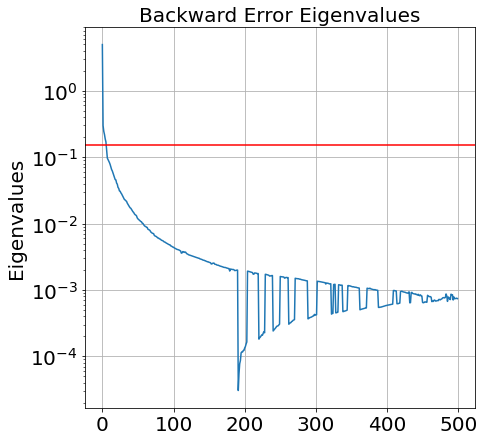

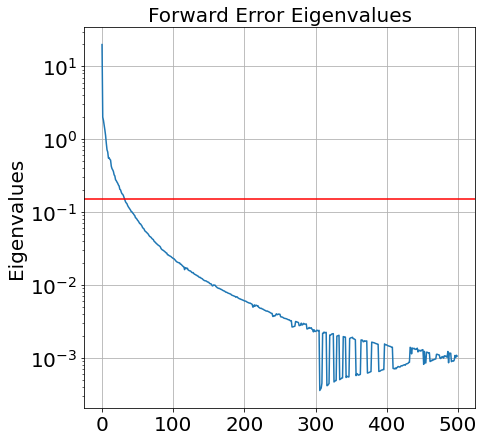

In [10]:
model = ContrastiveCorInfoMaxHopfield(architecture = architecture, lambda_ = lambda_,
                                        epsilon = epsilon, activation = activation)

hidden_layer_forward_error_corr = torch.zeros(hidden_size,hidden_size).to(device)
hidden_layer_backward_error_corr = torch.zeros(hidden_size,hidden_size).to(device)
for x, y in test_loader:
    x = x.view(x.size(0),-1).to(device).T
    y = y.to(device)

    mbs = x.size(1)
    neurons = model.init_neurons(x.size(1), device = model.device)

    # dynamics for T time steps
    neurons, _, _ = model.run_neural_dynamics_hopfield(x, 0, neurons, 
                                                       hopfield_g, neural_lr_start, neural_lr_stop, 
                                                       neural_lr_rule, neural_lr_decay_multiplier, 
                                                       neural_dynamic_iterations_free, beta = 0) 
    layers_free = [x] + neurons
    forward_errors_free = [layers_free[jj + 1] - (model.Wff[jj]['weight'] @ layers_free[jj]) for jj in range(len(model.Wff))]

    backward_errors_free = [(layers_free[jj]) - (model.Wfb[jj]['weight'] @ layers_free[jj + 1]) for jj in range(1, len(model.Wfb))]

    hidden_layer_forward_error_corr += torch.sum(outer_prod_broadcasting(forward_errors_free[0].T, forward_errors_free[0].T), axis = 0)
    hidden_layer_backward_error_corr += torch.sum(outer_prod_broadcasting(backward_errors_free[0].T, backward_errors_free[0].T), axis = 0)

hidden_layer_forward_error_corr = hidden_layer_forward_error_corr / (len(test_loader)  * test_loader.batch_size)
hidden_layer_backward_error_corr = hidden_layer_backward_error_corr / (len(test_loader)  * test_loader.batch_size)

print("Forward Eigenvalue ratio: ", (np.linalg.eig(torch2numpy(hidden_layer_forward_error_corr ))[0] < epsilon).sum() / hidden_size)
print("Backward Eigenvalue ratio: ", (np.linalg.eig(torch2numpy(hidden_layer_backward_error_corr ))[0] < epsilon).sum() / hidden_size)
    
plt.figure(figsize = (7,7))
plt.semilogy(np.linalg.eig(torch2numpy(hidden_layer_backward_error_corr ))[0])
plt.axhline(y=0.15, color='r', linestyle='-')
plt.grid()
plt.ylabel("Eigenvalues", fontsize =  20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.title("Backward Error Eigenvalues", fontsize =  20)
plt.show()

plt.figure(figsize = (7,7))
plt.semilogy(np.linalg.eig(torch2numpy(hidden_layer_forward_error_corr ))[0])
plt.axhline(y=0.15, color='r', linestyle='-')
plt.grid()
plt.ylabel("Eigenvalues", fontsize =  20)
plt.title("Forward Error Eigenvalues", fontsize =  20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()

In [11]:
RESULTS_DF = pd.DataFrame( columns = ['setting_number', 'seed', 'Model', 'Hyperparams', 'Trn_ACC_list', 'Tst_ACC_list', 'forward_backward_weight_angle_list'])

setting_number = 1
hyperparams_dict = {"lr_start" : lr_start, "lr_decay_multiplier" : lr_decay_multiplier,
                    "neural_dynamic_iterations_free" : neural_dynamic_iterations_free,
                    "neural_dynamic_iterations_nudged" : neural_dynamic_iterations_nudged,
                    "neural_lr_rule" : neural_lr_rule, "neural_lr" : neural_lr_start,
                    "epsilon" : epsilon, "lambda" : lambda_,
                    "architecture" : architecture,
                    "three_phase" : use_three_phase}
# for seed_ in seed_list:
#     np.random.seed(seed_)
#     torch.manual_seed(seed_)

trn_acc_list = []
tst_acc_list = []
model = ContrastiveCorInfoMaxHopfield(architecture = architecture, lambda_ = lambda_,
                                        epsilon = epsilon, activation = activation)
debug_iteration_point = 1


for epoch_ in range(n_epochs):
    if epoch_ < 15:
        lr = {'ff' : lr_start['ff'] * (lr_decay_multiplier)**epoch_, 'fb' : lr_start['fb'] * (lr_decay_multiplier)**epoch_}
    else:
        lr = {'ff' : lr_start['ff'] * (0.9)**epoch_, 'fb' : lr_start['fb'] * (0.9)**epoch_}
    for idx, (x, y) in tqdm(enumerate(train_loader)):
        x, y = x.to(device), y.to(device)
        x = x.view(x.size(0),-1).T
        y_one_hot = F.one_hot(y, 10).to(device).T
        take_debug_logs_ = (idx % 500 == 0)
        if use_random_sign_beta:
            rnd_sgn = 2*np.random.randint(2) - 1
            beta = rnd_sgn*beta

        neurons = model.batch_step_hopfield( x, y_one_hot, hopfield_g,
                                            lr, neural_lr_start, neural_lr_stop, neural_lr_rule,
                                            neural_lr_decay_multiplier, neural_dynamic_iterations_free,
                                            neural_dynamic_iterations_nudged, beta,
                                            use_three_phase, take_debug_logs_)

    trn_acc = evaluateContrastiveCorInfoMaxHopfield(model, train_loader, hopfield_g, neural_lr_start,
                                                    neural_lr_stop, neural_lr_rule,
                                                    neural_lr_decay_multiplier,
                                                    neural_dynamic_iterations_free,
                                                    device, printing = False)
    tst_acc = evaluateContrastiveCorInfoMaxHopfield(model, test_loader, hopfield_g, neural_lr_start,
                                                    neural_lr_stop, neural_lr_rule,
                                                    neural_lr_decay_multiplier,
                                                    neural_dynamic_iterations_free,
                                                    device, printing = False)
    hidden_layer_forward_error_corr = torch.zeros(hidden_size,hidden_size).to(device)
    hidden_layer_backward_error_corr = torch.zeros(hidden_size,hidden_size).to(device)
    for x, y in test_loader:
        x = x.view(x.size(0),-1).to(device).T
        y = y.to(device)

        mbs = x.size(1)
        neurons = model.init_neurons(x.size(1), device = model.device)

        # dynamics for T time steps
        neurons, _, _ = model.run_neural_dynamics_hopfield(x, 0, neurons, 
                                                           hopfield_g, neural_lr_start, neural_lr_stop, 
                                                           neural_lr_rule, neural_lr_decay_multiplier, 
                                                           neural_dynamic_iterations_free, beta = 0) 
        layers_free = [x] + neurons
        forward_errors_free = [layers_free[jj + 1] - (model.Wff[jj]['weight'] @ layers_free[jj]) for jj in range(len(model.Wff))]

        backward_errors_free = [(layers_free[jj]) - (model.Wfb[jj]['weight'] @ layers_free[jj + 1]) for jj in range(1, len(model.Wfb))]
    
        hidden_layer_forward_error_corr += torch.sum(outer_prod_broadcasting(forward_errors_free[0].T, forward_errors_free[0].T), axis = 0)
        hidden_layer_backward_error_corr += torch.sum(outer_prod_broadcasting(backward_errors_free[0].T, backward_errors_free[0].T), axis = 0)

    print("Forward Eigenvalue ratio: ", (np.linalg.eig(torch2numpy(hidden_layer_forward_error_corr / (len(test_loader)  * test_loader.batch_size)))[0] < epsilon).sum() / hidden_size)
    print("Backward Eigenvalue ratio: ", (np.linalg.eig(torch2numpy(hidden_layer_backward_error_corr / (len(test_loader)  * test_loader.batch_size)))[0] < epsilon).sum() / hidden_size)
    trn_acc_list.append(trn_acc)
    tst_acc_list.append(tst_acc)
    print("Epoch : {}, Train Accuracy : {}, Test Accuracy : {}".format(epoch_+1, trn_acc, tst_acc))



3000it [00:59, 50.24it/s]
0it [00:00, ?it/s]

Forward Eigenvalue ratio:  0.942
Backward Eigenvalue ratio:  0.972
Epoch : 1, Train Accuracy : 0.9140333333333334, Test Accuracy : 0.917


3000it [00:59, 50.36it/s]
0it [00:00, ?it/s]

Forward Eigenvalue ratio:  0.938
Backward Eigenvalue ratio:  0.97
Epoch : 2, Train Accuracy : 0.9328333333333333, Test Accuracy : 0.9358


3000it [00:59, 50.37it/s]
0it [00:00, ?it/s]

Forward Eigenvalue ratio:  0.932
Backward Eigenvalue ratio:  0.968
Epoch : 3, Train Accuracy : 0.9445833333333333, Test Accuracy : 0.9458


3000it [00:59, 50.46it/s]
0it [00:00, ?it/s]

Forward Eigenvalue ratio:  0.932
Backward Eigenvalue ratio:  0.966
Epoch : 4, Train Accuracy : 0.9504166666666667, Test Accuracy : 0.9498


3000it [00:59, 50.37it/s]
0it [00:00, ?it/s]

Forward Eigenvalue ratio:  0.928
Backward Eigenvalue ratio:  0.966
Epoch : 5, Train Accuracy : 0.95725, Test Accuracy : 0.9566


3000it [00:59, 50.18it/s]
0it [00:00, ?it/s]

Forward Eigenvalue ratio:  0.928
Backward Eigenvalue ratio:  0.964
Epoch : 6, Train Accuracy : 0.9596333333333333, Test Accuracy : 0.9586


3000it [00:59, 50.16it/s]
0it [00:00, ?it/s]

Forward Eigenvalue ratio:  0.928
Backward Eigenvalue ratio:  0.964
Epoch : 7, Train Accuracy : 0.9628, Test Accuracy : 0.9609


3000it [01:00, 49.91it/s]
0it [00:00, ?it/s]

Forward Eigenvalue ratio:  0.928
Backward Eigenvalue ratio:  0.964
Epoch : 8, Train Accuracy : 0.9654666666666667, Test Accuracy : 0.9628


3000it [01:00, 50.00it/s]
0it [00:00, ?it/s]

Forward Eigenvalue ratio:  0.926
Backward Eigenvalue ratio:  0.962
Epoch : 9, Train Accuracy : 0.9673666666666667, Test Accuracy : 0.9647


3000it [00:59, 50.14it/s]
0it [00:00, ?it/s]

Forward Eigenvalue ratio:  0.926
Backward Eigenvalue ratio:  0.962
Epoch : 10, Train Accuracy : 0.96815, Test Accuracy : 0.9636


3000it [00:59, 50.41it/s]
0it [00:00, ?it/s]

Forward Eigenvalue ratio:  0.924
Backward Eigenvalue ratio:  0.962
Epoch : 11, Train Accuracy : 0.96985, Test Accuracy : 0.965


3000it [00:59, 50.29it/s]
0it [00:00, ?it/s]

Forward Eigenvalue ratio:  0.922
Backward Eigenvalue ratio:  0.958
Epoch : 12, Train Accuracy : 0.9707166666666667, Test Accuracy : 0.9661


3000it [00:59, 50.18it/s]
0it [00:00, ?it/s]

Forward Eigenvalue ratio:  0.922
Backward Eigenvalue ratio:  0.958
Epoch : 13, Train Accuracy : 0.9711, Test Accuracy : 0.9666


3000it [00:59, 50.18it/s]
0it [00:00, ?it/s]

Forward Eigenvalue ratio:  0.92
Backward Eigenvalue ratio:  0.958
Epoch : 14, Train Accuracy : 0.9724666666666667, Test Accuracy : 0.9671


3000it [00:59, 50.10it/s]


Forward Eigenvalue ratio:  0.92
Backward Eigenvalue ratio:  0.958
Epoch : 15, Train Accuracy : 0.97305, Test Accuracy : 0.967


In [12]:
hidden_layer_forward_error_corr = torch.zeros(hidden_size,hidden_size).to(device)
hidden_layer_backward_error_corr = torch.zeros(hidden_size,hidden_size).to(device)

hidden_layer_forward_error_mean = torch.zeros(hidden_size).to(device)
for x, y in test_loader:
    x = x.view(x.size(0),-1).to(device).T
    y = y.to(device)
    
    mbs = x.size(1)
    neurons = model.init_neurons(x.size(1), device = model.device)

    # dynamics for T time steps
    neurons, _, _ = model.run_neural_dynamics_hopfield(x, 0, neurons, 
                                                       hopfield_g, neural_lr_start, neural_lr_stop, 
                                                       neural_lr_rule, neural_lr_decay_multiplier, 
                                                       neural_dynamic_iterations_free, beta = 0) 
    layers_free = [x] + neurons
    forward_errors_free = [layers_free[jj + 1] - (model.Wff[jj]['weight'] @ layers_free[jj]) for jj in range(len(model.Wff))]

    backward_errors_free = [(layers_free[jj]) - (model.Wfb[jj]['weight'] @ layers_free[jj + 1]) for jj in range(1, len(model.Wfb))]
    
    hidden_layer_forward_error_corr += torch.sum(outer_prod_broadcasting(forward_errors_free[0].T, forward_errors_free[0].T), axis = 0)
    hidden_layer_backward_error_corr += torch.sum(outer_prod_broadcasting(backward_errors_free[0].T, backward_errors_free[0].T), axis = 0)
    
    hidden_layer_forward_error_mean += forward_errors_free[0].sum(axis = 1)
    
hidden_layer_forward_error_corr = hidden_layer_forward_error_corr / (len(test_loader)  * test_loader.batch_size)
hidden_layer_backward_error_corr = hidden_layer_backward_error_corr / (len(test_loader)  * test_loader.batch_size)
hidden_layer_forward_error_mean = hidden_layer_forward_error_mean / (len(test_loader)  * test_loader.batch_size)

In [13]:
hidden_layer_forward_error_mean

tensor([-1.7935e-01, -2.7218e-01, -6.4401e-02,  9.8454e-01,  1.7719e-01,
         3.3096e-01,  1.1483e-01,  1.0943e-01,  9.0388e-02,  1.1203e-01,
         7.0240e-02, -3.2325e-01,  1.2479e-01,  4.4482e-01,  1.7229e-02,
         2.1181e-01,  1.2930e-01, -3.2073e-01,  2.4697e-01, -1.4887e-01,
         2.3850e-01,  9.4724e-02, -4.2990e-02, -4.5572e-01,  6.7241e-01,
        -6.2181e-02,  3.7488e-01,  2.9073e-02, -3.4055e-01,  2.2928e-01,
        -7.2960e-02, -1.7965e-03,  2.3178e-02,  1.3814e-01, -1.3304e-01,
        -8.9300e-01, -1.2813e-01, -6.1177e-02, -1.1740e-01,  7.4516e-01,
        -8.7182e-01,  2.9891e-01,  9.7598e-02,  3.1124e-01, -2.8044e-01,
         4.1958e-01, -1.2056e+00, -6.7717e-02, -3.0093e-01,  5.0888e-02,
        -8.2024e-02,  7.1789e-02, -1.4002e-02,  2.5330e-01, -8.7239e-01,
         8.6134e-02, -3.4350e-01,  3.5947e-02,  2.1294e-01, -1.6662e-01,
         8.0996e-02, -8.2221e-02,  1.4988e-01,  2.6508e-01,  5.3883e-02,
         1.6317e-02,  5.8287e-01, -2.1905e-02, -4.0

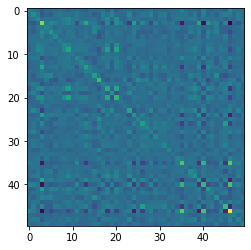

In [14]:
plt.imshow(torch2numpy(hidden_layer_forward_error_corr)[:50,:50])

In [15]:
(np.diag(torch2numpy(hidden_layer_forward_error_corr)) > epsilon).sum() / hidden_size

0.86

In [16]:
(np.linalg.eig(torch2numpy(hidden_layer_forward_error_corr))[0] < epsilon).sum() / hidden_size

0.92

In [17]:
(np.linalg.eig(torch2numpy(hidden_layer_backward_error_corr ))[0] < epsilon).sum() / hidden_size

0.958

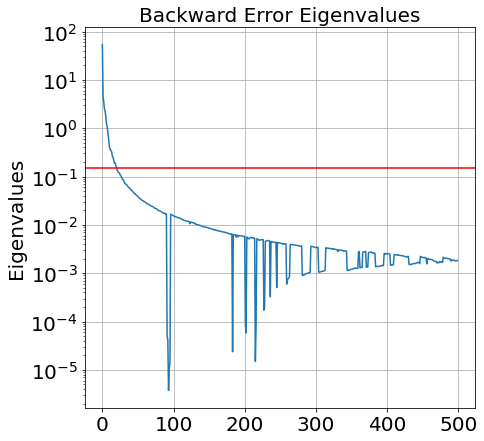

In [24]:
plt.figure(figsize = (7,7))
plt.semilogy(np.linalg.eig(torch2numpy(hidden_layer_backward_error_corr ))[0])
plt.axhline(y=0.15, color='r', linestyle='-')
plt.grid()
plt.ylabel("Eigenvalues", fontsize =  20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.title("Backward Error Eigenvalues", fontsize =  20)
plt.show()

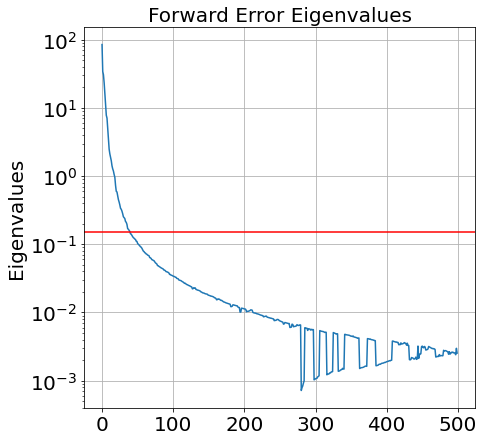

In [25]:
plt.figure(figsize = (7,7))
plt.semilogy(np.linalg.eig(torch2numpy(hidden_layer_forward_error_corr ))[0])
plt.axhline(y=0.15, color='r', linestyle='-')
plt.grid()
plt.ylabel("Eigenvalues", fontsize =  20)
plt.title("Forward Error Eigenvalues", fontsize =  20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()

In [20]:
torch.logdet(hidden_layer_backward_error_corr + epsilon * torch.eye(hidden_size).to(device))

tensor(-880.6201, device='cuda:0')

In [21]:
(torch.logdet(hidden_layer_backward_error_corr + epsilon * torch.eye(hidden_size).to(device)) - (torch.logdet(epsilon * torch.eye(hidden_size).to(device)) + (1/epsilon) * torch.trace(hidden_layer_backward_error_corr)))/ torch.logdet(hidden_layer_backward_error_corr + epsilon * torch.eye(hidden_size).to(device))

tensor(0.5223, device='cuda:0')

In [27]:
(torch.logdet(hidden_layer_forward_error_corr + epsilon * torch.eye(hidden_size).to(device)) - (torch.logdet(epsilon * torch.eye(hidden_size).to(device)) + (1/epsilon) * torch.trace(hidden_layer_forward_error_corr)))/ torch.logdet(hidden_layer_forward_error_corr + epsilon * torch.eye(hidden_size).to(device))

tensor(1.8967, device='cuda:0')

(array([ 82., 105.,  91.,  47.,  40.,  28.,  25.,  17.,   7.,  14.,   3.,
          7.,   2.,   3.,   6.,   2.,   4.,   3.,   1.,   2.,   1.,   3.,
          1.,   0.,   1.,   0.,   0.,   0.,   2.,   1.,   1.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   1.]),
 array([0.05983601, 0.16184196, 0.26384792, 0.36585388, 0.46785983,
        0.56986576, 0.6718717 , 0.7738777 , 0.87588364, 0.9778896 ,
        1.0798956 , 1.1819016 , 1.2839075 , 1.3859135 , 1.4879194 ,
        1.5899254 , 1.6919314 , 1.7939373 , 1.8959433 , 1.9979492 ,
        2.099955  , 2.201961  , 2.303967  , 2.405973  , 2.507979  ,
        2.6099849 , 2.7119908 , 2.8139968 , 2.9160028 , 3.0180087 ,
        3.1200147 , 3.2220206 , 3.3240266 , 3.4260325 , 3.5280385 ,
        3.6300445 , 3.7320504 , 3.8340564 , 3.9360623 , 4.0380683 ,
        4.1400743 , 4.24208   , 4.344086  , 4.446092  , 4.548098  ,
        4.650104  , 4.75211   , 4.854116  , 4.

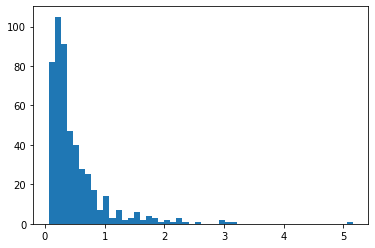

In [35]:
plt.hist(torch2numpy(torch.diag(hidden_layer_forward_error_corr)), bins= 50)

In [23]:
(torch.logdet(hidden_layer_forward_error_corr + epsilon * torch.eye(hidden_size).to(device)) - (torch.logdet(epsilon * torch.eye(hidden_size)) + (1 / epsilon) * torch.trace(hidden_layer_forward_error_corr))) / torch.logdet(hidden_layer_forward_error_corr + epsilon * torch.eye(hidden_size).to(device))

tensor(1.8967, device='cuda:0')

In [45]:
torch.logdet(hidden_layer_forward_error_corr + epsilon * torch.eye(hidden_size).to(device))

tensor(-1553.8209, device='cuda:0')

In [46]:
torch.logdet(epsilon * torch.eye(hidden_size))

tensor(-1897.1196)

In [47]:
(1 / epsilon) * torch.trace(hidden_layer_forward_error_corr)

tensor(5125.2539, device='cuda:0')

In [ ]:
(np.linalg.eig(torch2numpy(hidden_layer_forward_error_corr) - epsilon * np.eye(hidden_size,hidden_size))[0] > 0).sum() / hidden_size

In [ ]:
layers_free = [x] + neurons
forward_errors_free = [layers_free[jj + 1] - (model.Wff[jj]['weight'] @ layers_free[jj]) for jj in range(len(model.Wff))]

backward_errors_free = [(layers_free[jj]) - (model.Wfb[jj]['weight'] @ layers_free[jj + 1]) for jj in range(1, len(model.Wfb))]

In [ ]:
backward_errors_free[0].shape

In [ ]:
x.shape

In [ ]:
torch.sum(outer_prod_broadcasting(forward_errors_free[0].T, forward_errors_free[0].T), axis = 0).shape

In [ ]:
backward_errors_free[0]